In [65]:
import sys
import numpy as np
import pandas as pd
import MySQLdb
import matplotlib.pyplot as plt
sys.path.insert(0, '/home/kenleejr92/kenlee_home/energy_market_project/scripts/MySQL_scripts/')
from Query_ERCOT_DB import Query_ERCOT_DB
import cPickle as pickle
from datetime import datetime
import statsmodels.api as sm
import math

In [2]:
f = open('../time_series_clustering/LMP_2012_2015.pkl', 'rb')
df = pickle.load(f)

In [ ]:
def seasonal_decompose(node, start_date, end_date )

In [82]:
ts = df['CHERRYGROV02'].as_matrix()

In [ ]:
Seasonal Decomposition

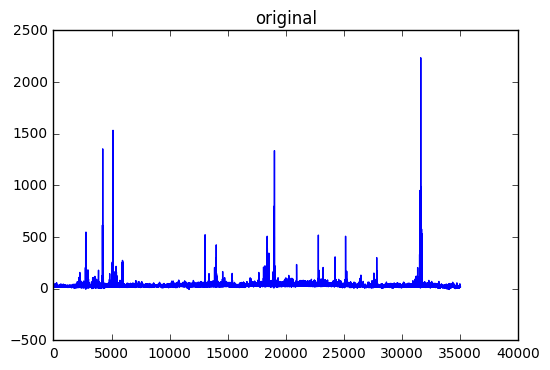

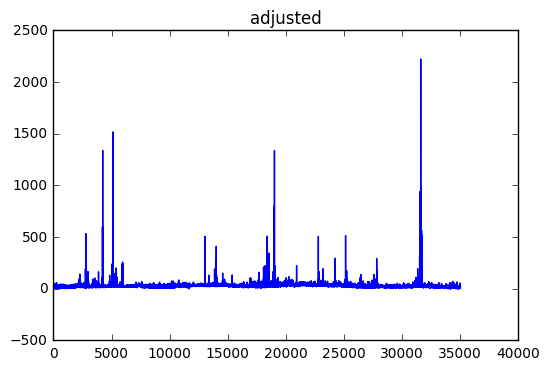

In [127]:
decompfreq = 24
res = sm.tsa.seasonal_decompose(ts, freq=decompfreq)
trend = res.trend
seas = res.seasonal
residual = res.resid
seasonal_adjustment = ts - seas
# resplot = res.plot()
# plt.show()
plt.figure(1)
plt.title('original')
plt.plot(ts)
plt.figure(2)
plt.title('adjusted')
plt.plot(seasonal_adjustment)

plt.show()

AutoCorrelation Function

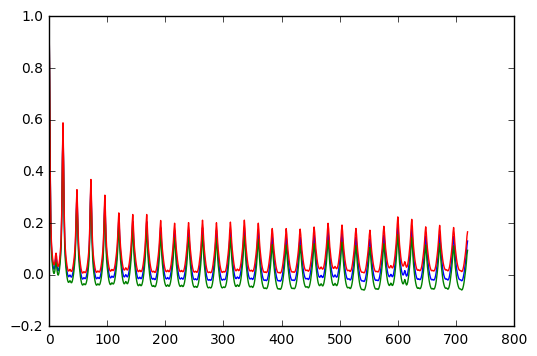

array([[ 1.        ,  1.        ],
       [ 0.74219243,  0.76314173],
       [ 0.3846392 ,  0.41523534],
       ..., 
       [ 0.04897462,  0.12038814],
       [ 0.07796223,  0.14941982],
       [ 0.09476198,  0.1662989 ]])

In [112]:
acf, confint = sm.tsa.stattools.acf(ts, nlags=720, alpha=0.05)
plt.plot(acf)
plt.plot(confint[:,0])
plt.plot(confint[:,1])
plt.show()